In [7]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [8]:
# Run the summarize script and capture output
result = subprocess.run(['./summarize_bestof.sh'], capture_output=True, text=True, cwd='/workspace/1.5-SPSA-LLM')
output = result.stdout
print(output)


                         1.5-SPSA BEST OF TRAINING (sorted by Best Test Acc)
n_perts | batch | lr       | progress    | best_train | best_val   | best_test  | status     | log
------------------------------------------------------------------------------------------------------------------------
40      | 512   | 0.0001   | 73/314      | 96.5%      | 96.8%      | 94.5%      | running    | job_np40_bs512
40      | 128   | 5e-05    | 290/1250    | 99.2%      | 95.9%      | 93.3%      | running    | job_np40_bs128
160     | 128   | 0.0001   | 74/313      | 98.4%      | 96.3%      | 93.1%      | running    | job_np160_bs128
640     | 512   | 0.0005   | 4/20        | 94.3%      | 96.1%      | 92.4%      | running    | job_np640_bs512
160     | 512   | 0.0003   | 18/78       | 95.7%      | 96.6%      | 92.2%      | running    | job_np160_bs512
640     | 128   | 0.0002   | 18/79       | 93.0%      | 93.1%      | 89.7%      | running    | job_np640_bs128
40      | 16    | 1e-07    | 2042/1000

In [9]:
# Parse the output to extract data
lines = output.strip().split('\n')

# Find data lines (they start with numbers)
data_rows = []
for line in lines:
    # Match lines: n_perts | batch | lr | progress | best_train | best_val | best_test | status | log
    match = re.match(r'^\s*(\d+)\s+\|\s+(\d+)\s+\|\s+[\d.e-]+\s+\|\s+[\d/]+\s+\|\s+[\d.]+%\s+\|\s+[\d.]+%\s+\|\s+([\d.]+)%', line)
    if match:
        n_perts = int(match.group(1))
        batch_size = int(match.group(2))
        best_test = float(match.group(3))
        data_rows.append({
            'n_perts': n_perts,
            'batch_size': batch_size,
            'best_test': best_test
        })

df = pd.DataFrame(data_rows)
print(f"Parsed {len(df)} data rows:")
df

Parsed 8 data rows:


,n_perts,batch_size,best_test
0,40,512,94.5
1,40,128,93.3
2,160,128,93.1
3,640,512,92.4
4,160,512,92.2
5,640,128,89.7
6,40,16,83.3
7,640,16,81.7


In [10]:
# Create pivot table for heatmap
# Row = batch_size (effective batch size), Column = n_perts
pivot_table = df.pivot_table(
    values='best_test', 
    index='batch_size', 
    columns='n_perts',
    aggfunc='mean'
)

# Sort index (batch_size) in ascending order (16 at top, 512 at bottom)
pivot_table = pivot_table.sort_index(ascending=True)

print("Pivot table (Best Test Accuracy):")
pivot_table

Pivot table (Best Test Accuracy):


n_perts,40,160,640
batch_size,,,
16,83.3,NaN,81.7
128,93.3,93.1,89.7
512,94.5,92.2,92.4


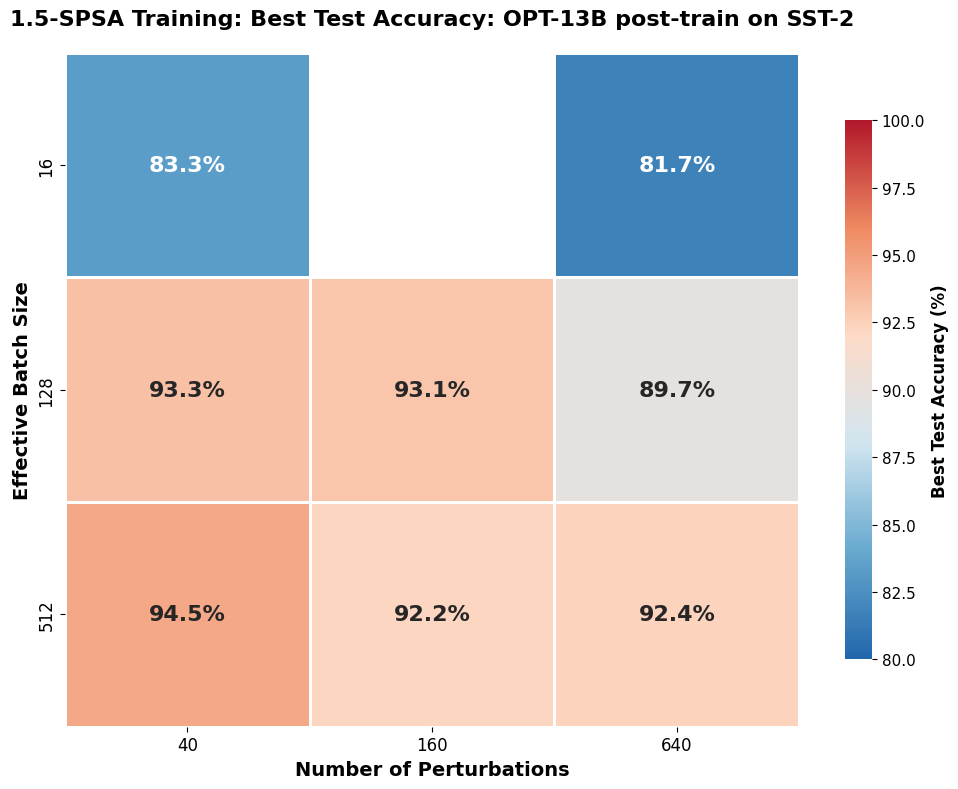


Heatmap saved to 'test_accuracy_heatmap.png'


In [12]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Create custom colormap from blue (80%) to red (100%)
from matplotlib.colors import LinearSegmentedColormap
colors = ['#2166ac', '#67a9cf', '#d1e5f0', '#fddbc7', '#ef8a62', '#b2182b']
cmap = LinearSegmentedColormap.from_list('blue_to_red', colors)

# Create annotation labels with 1 decimal place and % sign
annot_labels = pivot_table.map(lambda x: f'{x:.1f}%' if pd.notna(x) else '')

# Create heatmap
sns.heatmap(
    pivot_table,
    annot=annot_labels,
    fmt='',
    cmap=cmap,
    vmin=80,
    vmax=100,
    linewidths=2,
    linecolor='white',
    cbar_kws={
        'label': 'Best Test Accuracy (%)',
        'shrink': 0.8
    },
    annot_kws={'size': 16, 'weight': 'bold'},
    ax=ax
)

# Styling
ax.set_xlabel('Number of Perturbations', fontsize=14, fontweight='bold')
ax.set_ylabel('Effective Batch Size', fontsize=14, fontweight='bold')
ax.set_title('1.5-SPSA Training: Best Test Accuracy: OPT-13B post-train on SST-2', fontsize=16, fontweight='bold', pad=20)

# Adjust tick labels
ax.tick_params(axis='both', labelsize=12)

# Make colorbar label bold
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)
cbar.set_label('Best Test Accuracy (%)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('test_accuracy_heatmap.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nHeatmap saved to 'test_accuracy_heatmap.png'")